# Track Classifier

**Goal:** See how good the track classifer can do for just the track inputs, instead of using the hidden state of the RNN.

This will help tell us how much our network has learned about the track classification, so give us a handle for whether our network has learned what we're trying to teach it!


In [2]:
import uproot 
from skhep.math.vectors import LorentzVector, Vector3D
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import h5py
import sys

sys.path.append("..")
from usefulFcts import *

from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


### Track to jet association

For future presentations, I think it would be good to *plot* the curve that is used for the [track -> jet association](https://github.com/dguest/vr-jet-corner-cases/blob/22884119ab681c81c0d816f77840ec90b47e7750/plot_them.py#L13) cone! 

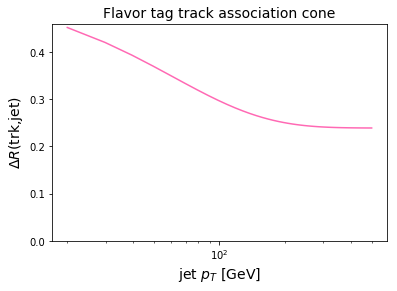

In [6]:
# There's a 20 GeV cut on b-jets
pt = np.linspace(20,500)
plt.semilogx(pt,ftag_cone(pt),'hotpink')
plt.xlabel('jet $p_T$ [GeV]',fontsize=14)
plt.ylabel('$\Delta R$(trk,jet)',fontsize=14)
plt.title('Flavor tag track association cone',fontsize=14)
plt.ylim(0,0.46)
plt.savefig('../figures/ftag_cone.pdf')
plt.show()

In [2]:
filepath = "../data/mc16d"
data_tag = "1k_15trks_sd0_rev"

jet_df = pd.read_hdf('{}/jet_{}.h5'.format(filepath,data_tag), key='jet_df')
trk_xr = xr.open_dataarray('{}/trk_{}.nc'.format(filepath,data_tag))

In [5]:
trk_xr.coords['var']

<xarray.DataArray 'var' (var: 31)>
array(['sd0', 'sz0', 'ip3d_d0', 'ip3d_z0', 'ip3d_grade', 'ip3d_llr', 'pt',
       'eta', 'theta', 'phi', 'orig', 'algo', 'nNextToInnHits', 'nInnHits',
       'nBLHits', 'nsharedBLHits', 'nsplitBLHits', 'nPixHits', 'nPixHoles',
       'nsharedPixHits', 'nsplitPixHits', 'nSCTHits', 'nSCTHoles',
       'nsharedSCTHits', 'expectBLayerHit', 'expectInnermostPixelLayerHit',
       'expectNextToInnermostPixelLayerHit', 'ptfrac', 'dr', 'prbP', 'pPerp'],
      dtype=object)
Coordinates:
  * var      (var) object 'sd0' 'sz0' 'ip3d_d0' ... 'dr' 'prbP' 'pPerp'

## Train a track classifer w/o the new variables from Vadim

Since each jet has multiple tracks, I'm going to try this with on 1k jets to see if this is sufficient. If not, overfitting is not the end of the world!


In [7]:
dataFile = "../data/mc16d"

vStr = "sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_"\
       +"nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits"
dataTag = "1k_15trks_{}_sd0_rev".format(vStr)

f1_name = "{}/data_{}_4trkClasses.hdf5".format(dataFile,dataTag)

In [10]:
f1 = h5py.File(f1_name,"r")
    
X_tr = f1['X_train'][:]
y_trk_tr = f1['y_trk_train'][:].astype(int)

X_te = f1['X_test'][:]
y_trk_te = f1['y_trk_test'][:].astype(int)

f1.close()

In [14]:
mask_tr = getTrkMask(X_tr)

In [16]:
X_trk_tr = X_tr[mask_tr]
X_trk_tr.shape

(2583, 13)

In [17]:
y_trk_tr = y_trk_tr[mask_tr]

In [18]:
y_trk_tr.shape

(2583,)

In [74]:
p = 0.2

model1 = Sequential()

model1.add(Dense(10, activation='relu',input_shape=(X_trk_tr.shape[1],),name="dense_1"))
# model1.add(Dropout(p,name="dropout"))
# model1.add(BatchNormalization(name='bn_1'))

# model1.add(Dense(25, activation='relu',name="dense_2"))
# model1.add(BatchNormalization(name='bn_2'))

model1.add(Dense(4,name='output'))

adam = Adam(lr=1e-4)
model1.compile(optimizer=adam,loss='categorical_crossentropy', metrics=['accuracy'])

model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                140       
_________________________________________________________________
output (Dense)               (None, 4)                 44        
Total params: 184
Trainable params: 184
Non-trainable params: 0
_________________________________________________________________


In [75]:
X_trk_tr.shape

(2583, 13)

In [76]:
y_trk_tr.shape

(2583,)

In [77]:
np.min(y_trk_tr),np.max(y_trk_tr)

(0, 3)

In [78]:
to_categorical(y_trk_tr)

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.]], dtype=float32)

In [79]:
nEpochs = 300

history = model1.fit(X_trk_tr,to_categorical(y_trk_tr),epochs=nEpochs,
                     validation_split=0.2)

Train on 2066 samples, validate on 517 samples
Epoch 1/300
2066/2066 [==============================] - 1s 484us/step - loss: 7.4173 - acc: 0.1350 - val_loss: 7.5212 - val_acc: 0.1103
Epoch 2/300
2066/2066 [==============================] - 0s 102us/step - loss: 7.3890 - acc: 0.1389 - val_loss: 7.4385 - val_acc: 0.1103
Epoch 3/300
2066/2066 [==============================] - 0s 97us/step - loss: 7.4105 - acc: 0.1409 - val_loss: 7.3323 - val_acc: 0.1161
Epoch 4/300
2066/2066 [==============================] - 0s 103us/step - loss: 7.4147 - acc: 0.1433 - val_loss: 7.3273 - val_acc: 0.1141
Epoch 5/300
2066/2066 [==============================] - 0s 103us/step - loss: 7.4165 - acc: 0.1399 - val_loss: 7.2463 - val_acc: 0.1161
Epoch 6/300
2066/2066 [==============================] - 0s 101us/step - loss: 7.4228 - acc: 0.1418 - val_loss: 7.1840 - val_acc: 0.1257
Epoch 7/300
2066/2066 [==============================] - 0s 102us/step - loss: 7.3940 - acc: 0.1476 - val_loss: 7.2360 - val_acc: 0.

Epoch 60/300
2066/2066 [==============================] - 0s 102us/step - loss: 7.3200 - acc: 0.2062 - val_loss: 7.2745 - val_acc: 0.2012
Epoch 61/300
2066/2066 [==============================] - 0s 102us/step - loss: 7.2619 - acc: 0.2067 - val_loss: 7.1904 - val_acc: 0.2089
Epoch 62/300
2066/2066 [==============================] - 0s 118us/step - loss: 7.2191 - acc: 0.2086 - val_loss: 7.1835 - val_acc: 0.2089
Epoch 63/300
2066/2066 [==============================] - 0s 103us/step - loss: 7.2324 - acc: 0.2086 - val_loss: 7.2703 - val_acc: 0.2050
Epoch 64/300
2066/2066 [==============================] - 0s 106us/step - loss: 7.2703 - acc: 0.2086 - val_loss: 7.2404 - val_acc: 0.2070
Epoch 65/300
2066/2066 [==============================] - 0s 103us/step - loss: 7.2508 - acc: 0.2081 - val_loss: 7.2350 - val_acc: 0.2050
Epoch 66/300
2066/2066 [==============================] - 0s 105us/step - loss: 7.2629 - acc: 0.2091 - val_loss: 7.2187 - val_acc: 0.2050
Epoch 67/300
2066/2066 [==========

2066/2066 [==============================] - 0s 104us/step - loss: 7.5700 - acc: 0.2986 - val_loss: 7.1059 - val_acc: 0.3017
Epoch 179/300
2066/2066 [==============================] - 0s 103us/step - loss: 7.5497 - acc: 0.2962 - val_loss: 7.1955 - val_acc: 0.2998
Epoch 180/300
2066/2066 [==============================] - 0s 104us/step - loss: 7.5246 - acc: 0.2914 - val_loss: 7.1794 - val_acc: 0.2901
Epoch 181/300
2066/2066 [==============================] - 0s 104us/step - loss: 7.5306 - acc: 0.2899 - val_loss: 7.1173 - val_acc: 0.2882
Epoch 182/300
2066/2066 [==============================] - 0s 90us/step - loss: 7.5123 - acc: 0.2870 - val_loss: 7.0413 - val_acc: 0.2805
Epoch 183/300
2066/2066 [==============================] - 0s 97us/step - loss: 7.4905 - acc: 0.2865 - val_loss: 7.1500 - val_acc: 0.2805
Epoch 184/300
2066/2066 [==============================] - 0s 103us/step - loss: 7.6204 - acc: 0.2841 - val_loss: 7.2669 - val_acc: 0.2766
Epoch 185/300
2066/2066 [==================

2066/2066 [==============================] - 0s 106us/step - loss: 6.5586 - acc: 0.2338 - val_loss: 6.2305 - val_acc: 0.2398
Epoch 238/300
2066/2066 [==============================] - 0s 102us/step - loss: 6.5355 - acc: 0.2323 - val_loss: 6.2034 - val_acc: 0.2418
Epoch 239/300
2066/2066 [==============================] - 0s 102us/step - loss: 6.5710 - acc: 0.2318 - val_loss: 6.2353 - val_acc: 0.2418
Epoch 240/300
2066/2066 [==============================] - 0s 103us/step - loss: 6.5400 - acc: 0.2323 - val_loss: 6.2240 - val_acc: 0.2418
Epoch 241/300
2066/2066 [==============================] - 0s 106us/step - loss: 6.5217 - acc: 0.2318 - val_loss: 6.2240 - val_acc: 0.2398
Epoch 242/300
2066/2066 [==============================] - 0s 103us/step - loss: 6.5015 - acc: 0.2299 - val_loss: 6.3314 - val_acc: 0.2398
Epoch 243/300
2066/2066 [==============================] - 0s 99us/step - loss: 6.5211 - acc: 0.2299 - val_loss: 6.2876 - val_acc: 0.2418
Epoch 244/300
2066/2066 [=================

In [80]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [81]:
epochs = range(nEpochs)

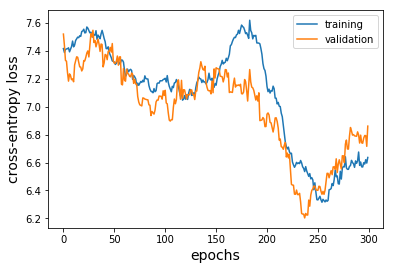

In [82]:
plt.plot(epochs,history.history['loss'],label='training')
plt.plot(epochs,history.history['val_loss'],label='validation')
plt.xlabel('epochs',fontsize=14)
plt.ylabel('cross-entropy loss',fontsize=14)
plt.legend()
plt.show()

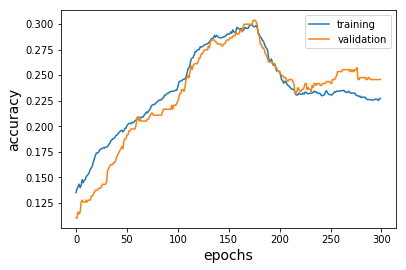

In [83]:
plt.plot(epochs,history.history['acc'],label='training')
plt.plot(epochs,history.history['val_acc'],label='validation')
plt.xlabel('epochs',fontsize=14)
plt.ylabel('accuracy',fontsize=14)
plt.legend()
plt.show()

Ok, either $\alpha$ is too small, or we don't have enough training data.

We should be able to overfit on the test set though, no?